In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap


# Load Data
selected_features_labeled = pd.read_csv("selected_features.csv", sep='\t')

c:\Bhavana\College\FURI_Project\FURI_Research-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Preprocessing

In [4]:
## data cleaning

# Check for missing values and zero-value columns
zero_counts = (selected_features_labeled == 0).sum()
print("Total missing values: ", selected_features_labeled.isnull().sum().sum())
print("Missing values per column:\n", selected_features_labeled.isnull().sum())
print("Columns with all zero values:\n", zero_counts)

# Drop unnecessary columns
selected_features_labeled = selected_features_labeled.drop(columns=['DID040', 'DIQ220', 'DIQ230', 'DID260', 'DIQ280', 'DIQ300S', 'DIQ300D'], errors='ignore')

# Drop rows where certain columns contain zeros
cols_to_check = ['LBXAPB', 'LBDINSI', 'LBXGH', 'PADDURAT', 'RIDAGEMN']
selected_features_labeled = selected_features_labeled[(selected_features_labeled[cols_to_check] != 0).all(axis=1)]

# Save cleaned data
selected_features_labeled.to_csv("selected_features_final.csv", sep='\t', index=False)


Total missing values:  0
Missing values per column:
 SEQN        0
BPQ020      0
DIQ010      0
DID040      0
DIQ220      0
DIQ190A     0
DIQ190B     0
DIQ230      0
DID260      0
DIQ280      0
DIQ300S     0
DIQ300D     0
PAQ180      0
PADACTIV    0
PADDURAT    0
SLD010H     0
LBXAPB      0
LBDINSI     0
LBXGH       0
RIAGENDR    0
RIDAGEMN    0
dtype: int64
Columns with all zero values:
 SEQN           0
BPQ020         0
DIQ010         0
DID040      4733
DIQ220      4914
DIQ190A        0
DIQ190B        0
DIQ230      4733
DID260      4765
DIQ280      4785
DIQ300S     4733
DIQ300D     4733
PAQ180         0
PADACTIV       0
PADDURAT       3
SLD010H        0
LBXAPB       349
LBDINSI      372
LBXGH        329
RIAGENDR       0
RIDAGEMN      32
dtype: int64


# 2. Data Preparation for Analysis
## Criteria Filtering

In [5]:
## preDM filter

# Reload cleaned dataset
combined_selected_features = pd.read_csv("selected_features_final.csv", sep='\t')

# Define PreDM condition
preDM_criteria = (combined_selected_features['LBDINSI'] >= 100) | (combined_selected_features['LBXAPB'] >= 110) | (combined_selected_features['LBXGH'] >= 5.5)

# Add 'PreDM' label
combined_selected_features['PreDM'] = preDM_criteria.astype(int)

# Drop features used for labeling
combined_selected_features = combined_selected_features.drop(columns=['LBDINSI', 'LBXAPB', 'LBXGH'], errors='ignore')

# Save final labeled dataset
combined_selected_features.to_csv("selected_features_labeled_final.csv", sep='\t', index=False)


In [6]:
# prepare data for analysis, train/test
# Load labeled dataset
labeled_selected_features = pd.read_csv("selected_features_labeled_final.csv", sep='\t')

# Define features and target
X = labeled_selected_features[['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'PADDURAT', 'SLD010H', 'RIAGENDR', 'RIDAGEMN']]
y = labeled_selected_features["PreDM"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 3. Model Training and Evaluation

In [7]:
## train/evaluate model

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}\n", classification_report(y_test, y_pred_dt))

# Logistic Regression
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log:.2f}\n", classification_report(y_test, y_pred_log_reg))

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train, verbose=False)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}\n", classification_report(y_test, y_pred_xgb))


Decision Tree Accuracy: 0.83
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       427
           1       0.83      0.84      0.84       481

    accuracy                           0.83       908
   macro avg       0.83      0.83      0.83       908
weighted avg       0.83      0.83      0.83       908

Logistic Regression Accuracy: 0.67
               precision    recall  f1-score   support

           0       0.63      0.75      0.68       427
           1       0.73      0.61      0.66       481

    accuracy                           0.67       908
   macro avg       0.68      0.68      0.67       908
weighted avg       0.68      0.67      0.67       908

XGBoost Accuracy: 0.81
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       427
           1       0.82      0.81      0.82       481

    accuracy                           0.81       908
   macro avg       0.81      0.81     

# 4. Cross Validation of Models

In [8]:
## cross-validation of models

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree CV
dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"Decision Tree Mean CV Accuracy: {dt_scores.mean():.2f}")

# Logistic Regression CV
lr_scores = cross_val_score(LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"Logistic Regression Mean CV Accuracy: {lr_scores.mean():.2f}")

# XGBoost CV
xgb_scores = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42, alpha=0.5), X_train_scaled, y_train, cv=kf, scoring='f1')
print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")


Decision Tree Mean CV Accuracy: 0.77
Logistic Regression Mean CV Accuracy: 0.63
XGBoost Mean CV Accuracy: 0.77


# 5. Confusion Matrix Analysis and Identifying Correct/Incorrect Values

In [9]:
## confusion matrix using XGBoost model

# Function to plot confusion matrix
def plot_confusion_matrix(cm, fold_num):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {fold_num}")
    #plt.savefig('final_visualizations/confusion_matrix.png')
    #plt.show()

# XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, alpha=0.5)

fold_cm = []
total_samples = 0
all_predictions = np.zeros(len(y))  # Start with zeros for all predictions

for fold_num, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)

    all_predictions[test_index] = y_pred_cv

    #print(y_pred_cv)

    cm = confusion_matrix(y_test_cv, y_pred_cv)
    fold_cm.append(cm)

    print(f"Confusion Matrix for Fold {fold_num}: \n{cm}\n")

     # Plot confusion matrix after each fold
    #plot_confusion_matrix(cm, fold_num)

# Compare predictions to actual values and label them as correct (1) or incorrect (0)
correct_predictions = (all_predictions == y).astype(int)

labeled_selected_features["Prediction_Correct"] = correct_predictions
    
labeled_selected_features.to_csv("selected_features_labeled_final_with_predictions.csv", sep='\t', index=False)

# Count of correct predictions (where Prediction_Correct == 1)
correct_count = labeled_selected_features["Prediction_Correct"].sum()

# Count of incorrect predictions (where Prediction_Correct == 0)
incorrect_count = len(labeled_selected_features) - correct_count

# Print the results
print(f"Correct Predictions: {correct_count}")
print(f"Incorrect Predictions: {incorrect_count}")

print(correct_predictions)


Confusion Matrix for Fold 1: 
[[352  75]
 [ 96 385]]

Confusion Matrix for Fold 2: 
[[386  68]
 [ 76 377]]

Confusion Matrix for Fold 3: 
[[396  80]
 [ 90 341]]

Confusion Matrix for Fold 4: 
[[360  80]
 [ 89 378]]

Confusion Matrix for Fold 5: 
[[390  80]
 [ 93 344]]

Correct Predictions: 3709
Incorrect Predictions: 827
0       1
1       1
2       1
3       1
4       1
       ..
4531    0
4532    1
4533    1
4534    1
4535    0
Name: PreDM, Length: 4536, dtype: int64


In [10]:
# comparison of correct and wrong values
correct = labeled_selected_features[labeled_selected_features['Prediction_Correct']==1]
wrong = labeled_selected_features[labeled_selected_features['Prediction_Correct']==0]

# 6. Analysis of Correct/Incorrect Values

In [11]:
# statistics of correct and wrong values
correct_desc = correct.describe()
wrong_desc = wrong.describe()
display(correct_desc)
display(wrong_desc)

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM,Prediction_Correct
count,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.000000,3709.0
mean,36458.781343,1.791049,1.955783,1.778647,1.720140,2.342950,29.456457,58.236452,6.982205,1.476678,431.528714,0.492046,1.0
std,2945.626356,0.406614,0.257963,0.433019,0.465505,0.876975,13.242288,64.654270,2.529269,0.499523,220.262094,0.500004,0.0
min,31132.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000,192.000000,0.000000,1.0
25%,33851.000000,2.000000,2.000000,2.000000,1.000000,2.000000,15.000000,20.000000,6.000000,1.000000,229.000000,0.000000,1.0
50%,36530.000000,2.000000,2.000000,2.000000,2.000000,2.000000,32.000000,30.000000,7.000000,1.000000,369.000000,0.000000,1.0
75%,38944.000000,2.000000,2.000000,2.000000,2.000000,3.000000,42.000000,60.000000,8.000000,2.000000,587.000000,1.000000,1.0
max,41465.000000,2.000000,3.000000,9.000000,9.000000,9.000000,71.000000,600.000000,99.000000,2.000000,1019.000000,1.000000,1.0


,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM,Prediction_Correct
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.00000,827.0
mean,36459.123337,1.859734,2.004837,1.899637,1.810157,2.218863,29.522370,59.593712,7.128174,1.489722,428.523579,0.53688,0.0
std,3024.979032,0.569322,0.264942,0.300665,0.392414,0.811081,13.697101,66.847967,3.468714,0.500197,215.292094,0.49894,0.0
min,31153.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,3.000000,1.000000,192.000000,0.00000,0.0
25%,33973.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000,22.500000,6.000000,1.000000,240.000000,0.00000,0.0
50%,36301.000000,2.000000,2.000000,2.000000,2.000000,2.000000,34.000000,30.000000,7.000000,1.000000,367.000000,1.00000,0.0
75%,39107.000000,2.000000,2.000000,2.000000,2.000000,3.000000,42.000000,60.000000,8.000000,2.000000,559.000000,1.00000,0.0
max,41472.000000,9.000000,9.000000,2.000000,2.000000,9.000000,71.000000,600.000000,99.000000,2.000000,1019.000000,1.00000,0.0


In [12]:
# correct prediction versus wrong prediction

# correct and wrong values 

correct.to_csv("selected_features_final_with_predictions_correctValues.csv", sep='\t')
wrong.to_csv("selected_features_final_with_predictions_wrongValues.csv", sep='\t')

In [13]:
# Transpose the correct and wrong values to make it suitable for pairplot (each column represents a feature)

correct_transposed = correct.T
wrong_transposed = wrong.T

print(correct_transposed)
print(wrong_transposed)

                       0        1        2        3        4        5     \
SEQN                31132.0  31132.0  31134.0  31148.0  31150.0  31150.0   
BPQ020                  1.0      1.0      1.0      2.0      2.0      2.0   
DIQ010                  1.0      1.0      2.0      2.0      2.0      2.0   
DIQ190A                 1.0      1.0      1.0      2.0      2.0      2.0   
DIQ190B                 1.0      1.0      1.0      2.0      2.0      2.0   
PAQ180                  2.0      2.0      3.0      2.0      4.0      4.0   
PADACTIV               42.0     19.0     42.0     23.0     43.0     55.0   
PADDURAT               40.0    240.0     30.0     60.0     60.0     30.0   
SLD010H                 7.0      7.0      7.0      7.0      8.0      8.0   
RIAGENDR                1.0      1.0      1.0      2.0      1.0      1.0   
RIDAGEMN              842.0    842.0    882.0    194.0    959.0    959.0   
PreDM                   1.0      1.0      1.0      0.0      0.0      0.0   
Prediction_C

KeyboardInterrupt: 

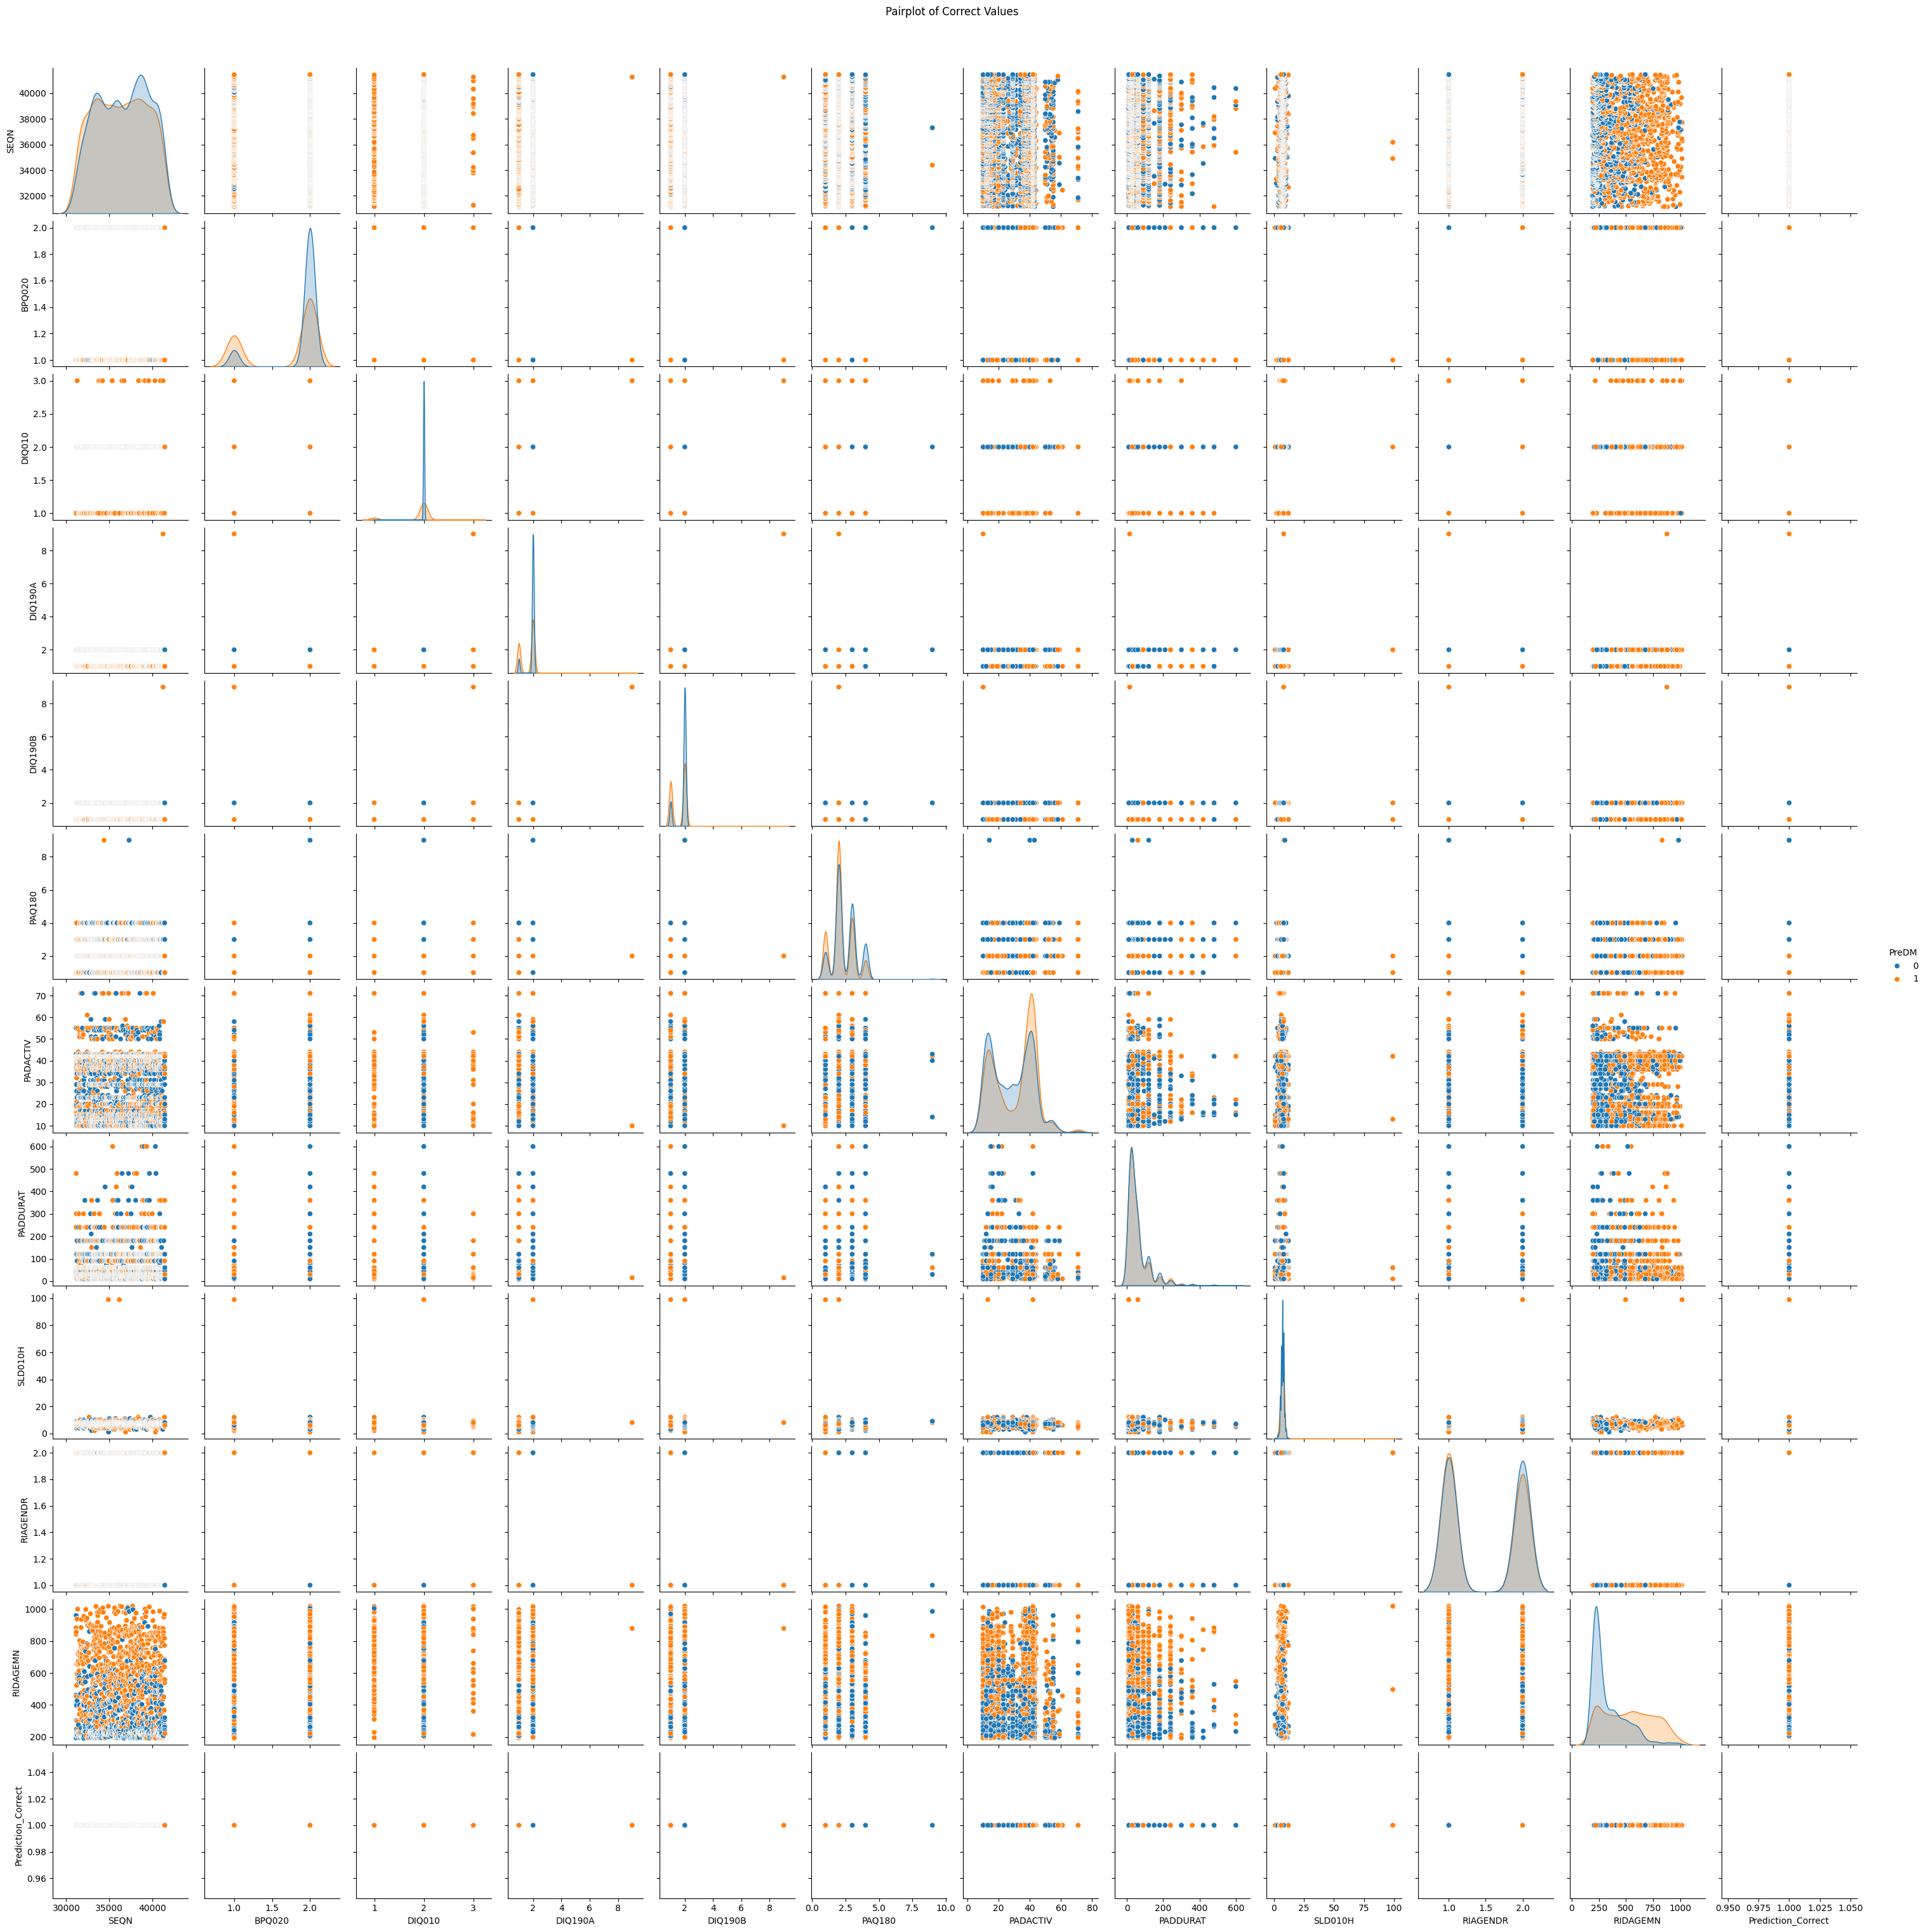

In [14]:
## pairplot of correct and wrong values

sns.pairplot(correct, hue='PreDM', diag_kind='kde')
plt.suptitle("Pairplot of Correct Values ", y=1.02)
#sns.pairplot(labeled_selected_features, vars=renamed_vars, hue='PreDM', diag_kind='kde')
plt.savefig("final_visualizations/pairplot_correct_values.png")

sns.pairplot(wrong,  hue='PreDM', diag_kind='kde')
plt.suptitle("Pairplot of Wrong Values ", y=1.02)
plt.savefig("final_visualizations/pairplot_wrong_values.png")

#plt.show()

# 7. Visualizations of Dataset
## SHAP values

Shape of X: (4536, 10)
Shape of shap_values: (4536, 10)


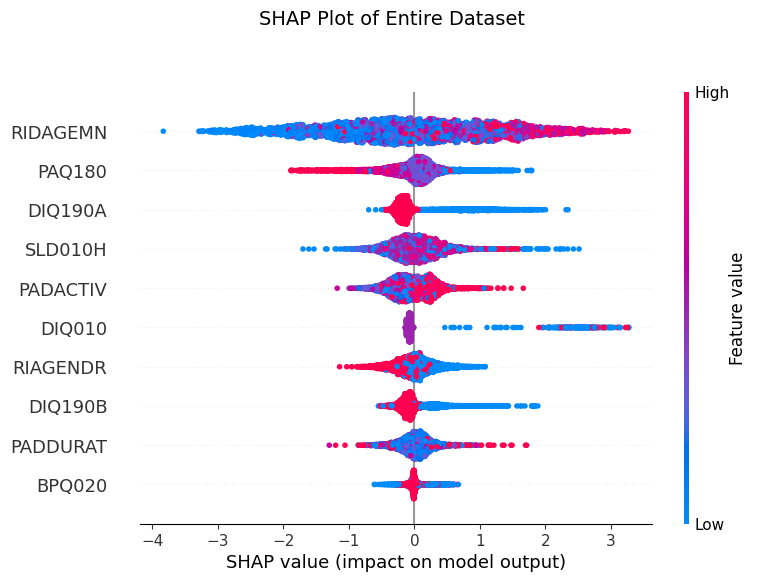

In [37]:
# SHAP values visualization using xgboost - entire dataset

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

print("Shape of X:", X.shape)
print("Shape of shap_values:", shap_values.shape)

shap.summary_plot(shap_values, X, show=False)

plt.suptitle("SHAP Plot of Entire Dataset ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_entireDataset.png", bbox_inches='tight', dpi=300)
plt.show()


Shape of Correct Values (features only): (3709, 10)
Shape of shap_values_correct: (3709, 10)


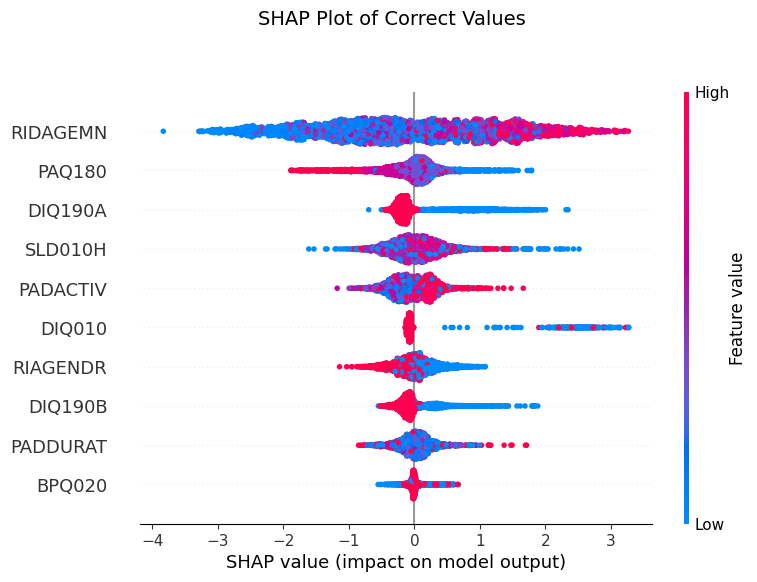

In [ ]:
# SHAP values visualization using xgboost - correct values
# training data - X_train
feature_names = X_train.columns.tolist()

#feature_names = xgb_model.feature_names
features_only_correct = correct[feature_names]

explainer = shap.TreeExplainer(xgb_model)
shap_values_correct = explainer.shap_values(features_only_correct)

print("Shape of Correct Values (features only):", features_only_correct.shape)
print("Shape of shap_values_correct:", shap_values_correct.shape)

shap.summary_plot(shap_values_correct, features_only_correct, show=False)

plt.suptitle("SHAP Plot of Correct Values ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_correctValues.png", bbox_inches='tight', dpi=300)
plt.show()


Shape of Wrong Values (features only): (827, 10)
Shape of shap_values_wrong: (827, 10)


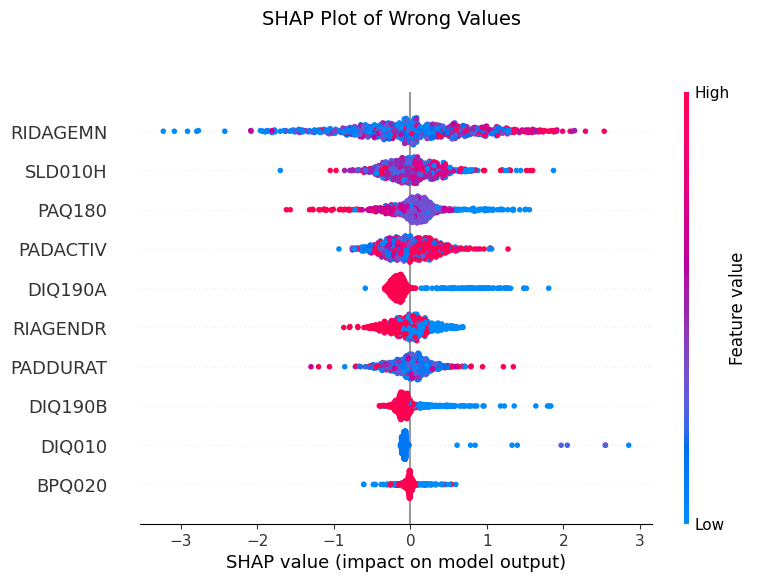

In [39]:
# SHAP values visualization using xgboost - wrong values
# training data - X_train
feature_names = X_train.columns.tolist()

#feature_names = xgb_model.feature_names
features_only_wrong = wrong[feature_names]

explainer = shap.TreeExplainer(xgb_model)
shap_values_wrong = explainer.shap_values(features_only_wrong)

print("Shape of Wrong Values (features only):", features_only_wrong.shape)
print("Shape of shap_values_wrong:", shap_values_wrong.shape)

shap.summary_plot(shap_values_wrong, features_only_wrong, show=False)

plt.suptitle("SHAP Plot of Wrong Values ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_wrongValues.png", bbox_inches='tight', dpi=300)
plt.show()
